# Random Forest Regression for Cherry Blossom Bloom Day
#
# This notebook trains a Random Forest regression model to predict cherry blossom bloom day.
# It mirrors the OLS, SARIMAX, and LightGBM notebooks: same data splits, metrics, and plotting style.


In [3]:
# Plan and assumptions
#
# - Use the same numeric predictors as in the other notebooks.
# - Use years 1921–2015 as the pool for training/validation and perform a sequential 80/20 split to preserve temporal order.
# - Reserve 2016–2025 as the test set and report performance on that set.
# - Metrics: RMSE, MAE, and WMAPE (sum(|error|) / sum(|actual|)).
# - We'll use RandomForestRegressor with GridSearchCV for hyperparameter tuning.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

sns.set_theme(style='whitegrid')


# 1) Load data

In [5]:
DATA_PATH = '../data/cherry_blossom_data.csv'
df = pd.read_csv(DATA_PATH)
print('Loaded rows:', len(df))
# df.head()  # Uncomment to inspect


Loaded rows: 107


# 2) Prepare features and target

In [6]:
numeric_cols = ['days_dec_ge_45','days_jan_ge_45','days_feb_ge_45','prec_winter',
                'mean_temp_winter','surface_temp_chg','climate_incidents']
for c in numeric_cols + ['bloom_day','year']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.dropna(subset=['year','bloom_day'] + numeric_cols).reset_index(drop=True)

FEATURES = numeric_cols
TARGET = 'bloom_day'


# 3) Create train / validation / test splits (sequential)

In [7]:
train_val_df = df[(df['year'] >= 1921) & (df['year'] <= 2015)].sort_values('year').reset_index(drop=True)
test_df = df[(df['year'] >= 2016) & (df['year'] <= 2025)].sort_values('year').reset_index(drop=True)

print(f'Train/Val rows: {len(train_val_df)}, Test rows: {len(test_df)}')

n = len(train_val_df)
if n == 0:
    raise ValueError('No data in 1921-2015 range to train/validate on.')
train_n = int(np.floor(n * 0.8))
train_df = train_val_df.iloc[:train_n].reset_index(drop=True)
val_df = train_val_df.iloc[train_n:].reset_index(drop=True)

print(f'Train rows: {len(train_df)}, Val rows: {len(val_df)}')

X_train = train_df[FEATURES]
y_train = train_df[TARGET]
X_val = val_df[FEATURES]
y_val = val_df[TARGET]
X_test = test_df[FEATURES]
y_test = test_df[TARGET] if len(test_df) > 0 else None

full_years = df['year']
full_actuals = df[TARGET]


Train/Val rows: 97, Test rows: 10
Train rows: 77, Val rows: 20


# 4) Hyperparameter tuning with GridSearchCV

In [8]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
gs = GridSearchCV(rf, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best params: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


/Users/ecilteodoro/miniconda3/envs/cherry-blossom-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
169 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ecilteodoro/miniconda3/envs/cherry-blossom-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ecilteodoro/miniconda3/envs/cherry-blossom-env/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/ecilteodoro/miniconda3/envs/cherry-blossom-env/l

# 5) Train Random Forest with best hyperparameters

In [9]:
best_rf = RandomForestRegressor(**gs.best_params_, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_split=5,
                      n_estimators=300, n_jobs=-1, random_state=42)

# 6) Validation diagnostics

In [10]:
val_pred = best_rf.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
val_mae = mean_absolute_error(y_val, val_pred)
val_wmape = np.sum(np.abs(y_val - val_pred)) / np.sum(np.abs(y_val))

print('Validation RMSE: {:.3f}'.format(val_rmse))
print('Validation MAE: {:.3f}'.format(val_mae))
print('Validation WMAPE: {:.3%}'.format(val_wmape))


Validation RMSE: 6.258
Validation MAE: 4.663
Validation WMAPE: 5.118%


# 7) Evaluate on test set (2016-2025)

In [11]:
y_pred_test = None
if len(test_df) == 0:
    print('No test data available for 2016-2025 range.')
else:
    y_pred_test = best_rf.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_wmape = np.sum(np.abs(y_test - y_pred_test)) / np.sum(np.abs(y_test))

    print('\nTest set performance (2016-2025)')
    print('Rows:', len(test_df))
    print('RMSE: {:.3f}'.format(test_rmse))
    print('MAE: {:.3f}'.format(test_mae))
    print('WMAPE: {:.3%}'.format(test_wmape))



Test set performance (2016-2025)
Rows: 10
RMSE: 8.233
MAE: 7.145
WMAPE: 8.426%


# 8) Feature importance

/var/folders/qk/h9ncn2v54gb9mbzz0vjllrz80000gn/T/ipykernel_23237/1860757616.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='importance', y='feature', palette='viridis')


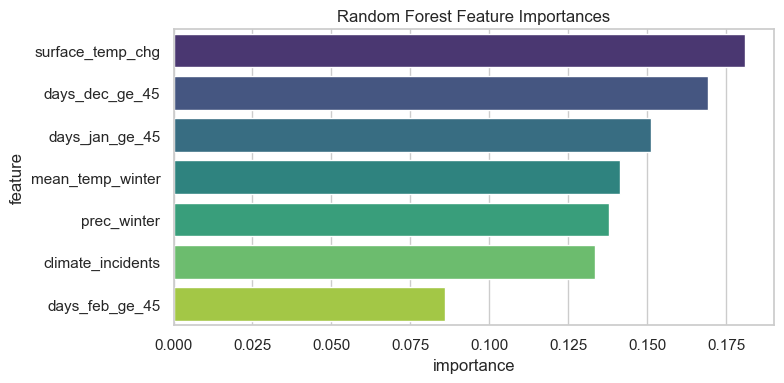

In [12]:
importances = pd.DataFrame({'feature': FEATURES, 'importance': best_rf.feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)
plt.figure(figsize=(8, 4))
sns.barplot(data=importances, x='importance', y='feature', palette='viridis')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()


# 9) Plot actuals (since 1921) and forecasts (2016-2025) with a dashed vertical line at 2016

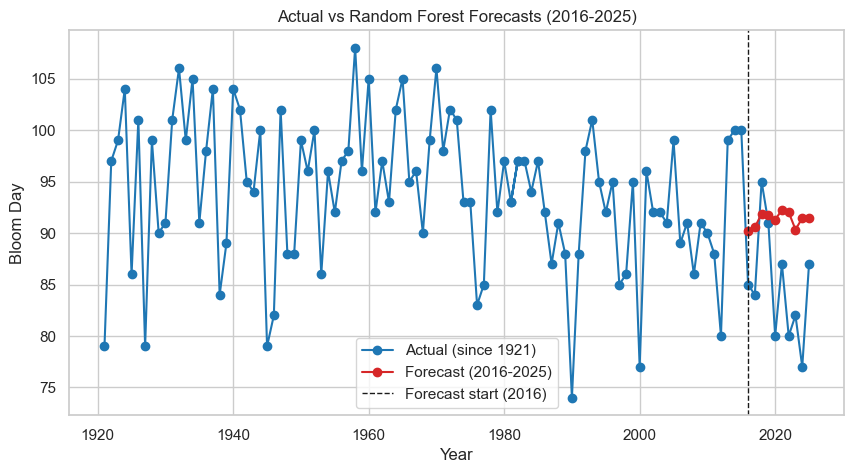

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(full_years, full_actuals.values, marker='o', color='tab:blue', label='Actual (since 1921)')

if len(test_df) > 0 and y_pred_test is not None:
    plt.plot(test_df['year'], y_pred_test, marker='o', color='tab:red', label='Forecast (2016-2025)')
    plt.axvline(2016, color='k', linestyle='--', linewidth=1, label='Forecast start (2016)')

plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.title('Actual vs Random Forest Forecasts (2016-2025)')
plt.legend()
plt.grid(True)
plt.show()


# 10) Notes and next steps

- This Random Forest model provides a non-linear, ensemble-based approach. If you'd like, I can:
  - Add more advanced hyperparameter tuning (RandomizedSearchCV, Optuna).
  - Use time-series CV folds for more robust validation.
  - Add SHAP explanations for local/global interpretability.
